<a href="https://colab.research.google.com/github/sabre-code/flower_classification/blob/main/classification_tfds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [ ]:
print(tf.__version__)

2.9.2


In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin = dataset_url, fname = 'flower_photos', untar = True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 10s 0us/step


In [ ]:
image_count = len((list(data_dir.glob('*/*.jpg'))))
print("Total Images: ",image_count)

Total Images:  3670


In [ ]:
rose = list(data_dir.glob('roses/*'))
sunflower = list(data_dir.glob('sunflowers/*'))
tulips = list(data_dir.glob('tulips/*'))
dandelion = list(data_dir.glob('dandelion/*'))
daisy = list(data_dir.glob('daisy/*'))

print("Total Roses :",len(rose))
print("Total Sunflowers :",len(sunflower))
print("Total Tulips :",len(tulips))
print("Total Dandelion :",len(dandelion))
print("Total Daisy :",len(daisy))

Total Roses : 641
Total Sunflowers : 699
Total Tulips : 799
Total Dandelion : 898
Total Daisy : 633


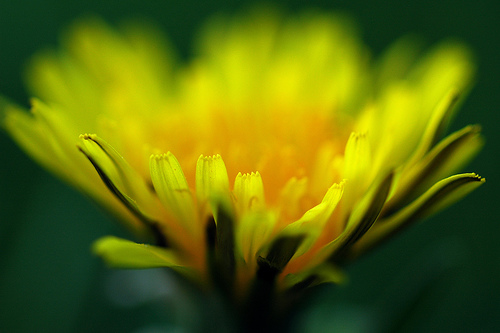

In [ ]:
PIL.Image.open(str(dandelion[43]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 7,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
tf.random.set_seed(50)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 7,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


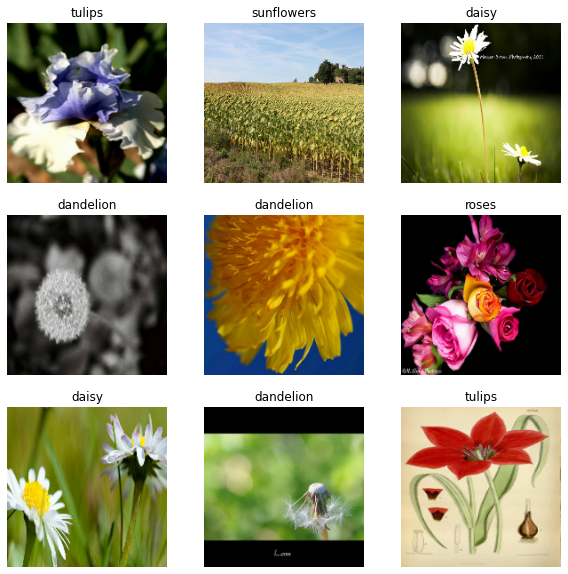

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)


In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3,kernel_regularizer=regularizers.l2(l2=0.001), kernel_initializer= 'he_uniform', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, kernel_regularizer=regularizers.l2(0.001), kernel_initializer= 'he_uniform', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, kernel_regularizer=regularizers.l2(0.001), kernel_initializer= 'he_uniform', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Conv2D(128, 3, kernel_regularizer=regularizers.l2(0.001), kernel_initializer= 'he_uniform', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:

opt = tf.keras.optimizers.Adam(learning_rate=0.00085)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                      

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size = 50,
  epochs=epochs
)


Epoch 1/50
92/92 [==============================] - 20s 65ms/step - loss: 2.5510 - accuracy: 0.2956 - val_loss: 1.8010 - val_accuracy: 0.4510
Epoch 2/50
92/92 [==============================] - 4s 48ms/step - loss: 1.6534 - accuracy: 0.4598 - val_loss: 1.6397 - val_accuracy: 0.4986
Epoch 3/50
92/92 [==============================] - 4s 48ms/step - loss: 1.5130 - accuracy: 0.5269 - val_loss: 1.5578 - val_accuracy: 0.5381
Epoch 4/50
92/92 [==============================] - 4s 48ms/step - loss: 1.4418 - accuracy: 0.5467 - val_loss: 1.4833 - val_accuracy: 0.5422
Epoch 5/50
92/92 [==============================] - 4s 48ms/step - loss: 1.3814 - accuracy: 0.5651 - val_loss: 1.4919 - val_accuracy: 0.5681
Epoch 6/50
92/92 [==============================] - 4s 48ms/step - loss: 1.3253 - accuracy: 0.5960 - val_loss: 1.3760 - val_accuracy: 0.6144
Epoch 7/50
92/92 [==============================] - 4s 48ms/step - loss: 1.2467 - accuracy: 0.6209 - val_loss: 1.3059 - val_accuracy: 0.5954
Epoch 8/50
9

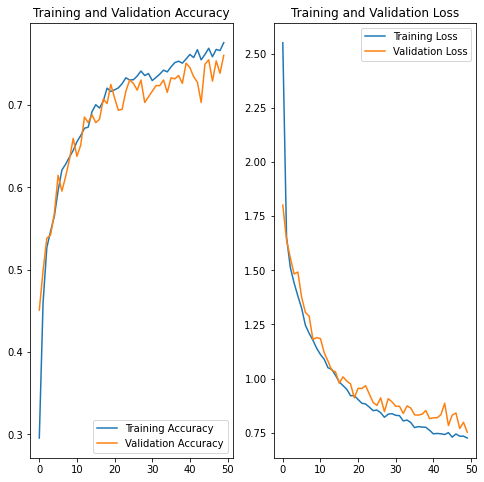

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
from tensorflow.keras.models import save_model
model.save("saved_model/my_model")

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
rose_url = "https://upload.wikimedia.org/wikipedia/commons/6/64/Garden_roses_%28yellow-red%29.jpg"
rose_path = tf.keras.utils.get_file('rose', origin=rose_url)

img = tf.keras.utils.load_img(
    rose_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 214ms/step
This image most likely belongs to roses with a 92.79 percent confidence.


In [ ]:
from tensorflow.keras.models import save_model
model.save("saved_model/my_model")

In [ ]:
https://docs.google.com/document/d/1YtIdpRkkUvCOPPDqI7jGpW5h6d526XZGEattmqpaDj8/edit?usp=drivesdk